# Common Test I. Multi-Class Classification


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset , random_split
from torchvision import models,transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.preprocessing import label_binarize,LabelEncoder

from tqdm import tqdm
import warnings

# set seed
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Creating  custom dataset class


In [2]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transforms=None):
        self.folder_path = folder_path
        self.class_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
        
        # Initialize LabelEncoder
        self.label_encoder = LabelEncoder()
        
        # Fit and transform class labels to numerical labels
        self.labels = self.label_encoder.fit_transform(self.class_folders)
        self.transform = transforms
        self.data = []
        
        for class_folder in self.class_folders:
            class_path = os.path.join(folder_path, class_folder)
            file_list = [f for f in os.listdir(class_path) if f.endswith('.npy')]

            for file_name in file_list:
                file_path = os.path.join(class_path, file_name)
                data_point = np.load(file_path)
                self.data.append((data_point, class_folder))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point, class_name = self.data[idx]
        label = self.label_encoder.transform([class_name])[0]
        
        data_point = (data_point - np.mean(data_point, axis=(1,2)))/(np.std(data_point, axis=(1,2)))
        
        # Convert NumPy array to PyTorch tensor
        data_point = torch.from_numpy(data_point).float()

        if self.transform:
            data_point = self.transform(data_point)
        return data_point, label
    

In [3]:
class Resnet_model(nn.Module):
    def __init__(self, num_classes):
        super(Resnet_model, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first convolutional layer to accept a single input channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

In [4]:
size = 224

augmentation = transforms.Compose([
    transforms.Resize(size),
])

folder_path = '/kaggle/input/deeplense-dataset-task1/dataset/train'
custom_dataset = CustomDataset(folder_path, transforms=augmentation)


# Define the size of the training and testing sets[90:10]
train_size = int(0.9 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Define the batch size for your DataLoader
batch_size = 256

# Create DataLoader for training set with shuffling
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set without shuffling
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Validation dataloader
folder_path_val = 'dataset/dataset/val/'
custom_dataset_val = CustomDataset(folder_path, transforms=augmentation)

# You can use shuffle=True to shuffle the data during training
val_dataloader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=True)

In [8]:
# !kill -9 -1

In [5]:
# Instantiate model, loss function and optimizer
model = Resnet_model(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            _, predicted = torch.max(test_outputs, 1)
            total_samples += test_labels.size(0)
            total_correct += (predicted == test_labels).sum().item()

    # Calculate accuracy
    accuracy = total_correct / total_samples

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), '/kaggle/working/Resnet-18.pth')
        
    # Print training and validation statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {avg_loss}, Accuracy on Test set: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


Epoch 1/20, Test Loss: 1.0990937042911098, Accuracy on Test set: 40.10%
Epoch 2/20, Test Loss: 0.7031077691968882, Accuracy on Test set: 70.90%
Epoch 3/20, Test Loss: 0.37396989861186947, Accuracy on Test set: 82.90%
Epoch 4/20, Test Loss: 0.287525475025177, Accuracy on Test set: 84.23%
Epoch 5/20, Test Loss: 0.22715671219915715, Accuracy on Test set: 90.77%
Epoch 6/20, Test Loss: 0.19496443403779334, Accuracy on Test set: 85.37%
Epoch 7/20, Test Loss: 0.18082852401542213, Accuracy on Test set: 90.87%
Epoch 8/20, Test Loss: 0.1587808274154393, Accuracy on Test set: 91.27%
Epoch 9/20, Test Loss: 0.13911694787302106, Accuracy on Test set: 90.00%
Epoch 10/20, Test Loss: 0.11047931416135914, Accuracy on Test set: 91.07%
Epoch 11/20, Test Loss: 0.10593357794689683, Accuracy on Test set: 90.90%
Epoch 12/20, Test Loss: 0.0872243580074524, Accuracy on Test set: 90.70%
Epoch 13/20, Test Loss: 0.07426822138071623, Accuracy on Test set: 90.50%
Epoch 14/20, Test Loss: 0.0600127623644921, Accuracy 

# Evaluating on test set


In [6]:
checkpoint = "/kaggle/working/Resnet-18.pth"
model = Resnet_model(num_classes=3).to(device)
model.load_state_dict(torch.load(checkpoint))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-6-198e344e46d6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

<All keys matched successfully>

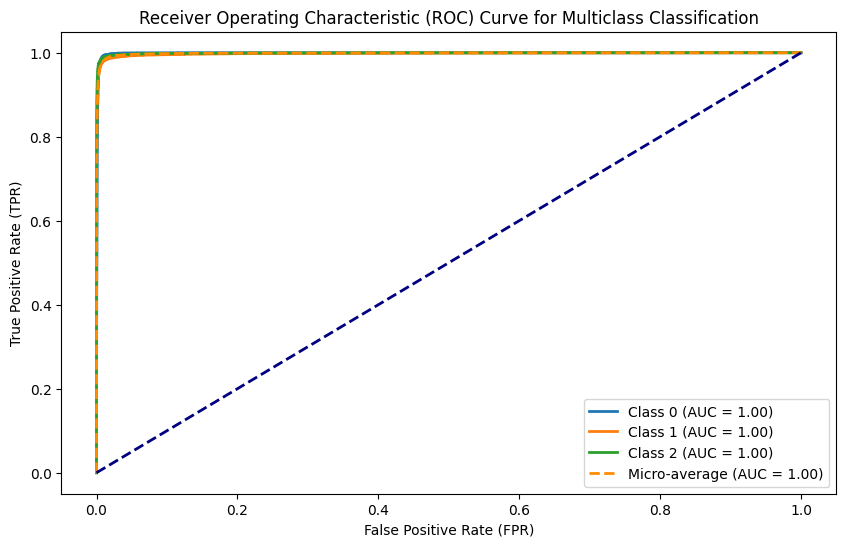

In [7]:
model.eval()
num_classes = 3
all_labels = []
all_scores = []

with torch.no_grad():
    for val_inputs, val_labels in val_dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        
        # Assuming the model outputs raw logits, apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        
        all_labels.extend(val_labels.cpu().numpy())
        all_scores.extend(probabilities.cpu().numpy())

# Binarize the labels
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Ensure y_true and all_scores are numpy arrays
y_true = np.array(y_true)
all_scores = np.array(all_scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='darkorange', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()